# File and libraries

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


#filepath=r'dataset/df_ecom_2_3_outliers_input_v2'

filepath=r'dataset/df_ecom_2_4_scaler_input_v2'

file_tag = "df_ecom_balancing_input"

# DSLabs functions

In [12]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [11]:
%run "data_functions.py"


data_functions loaded


# Load

In [31]:
test_data=False
# test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(f"{filepath}_test.csv")
    train= pd.read_csv(f"{filepath}_train.csv")

    # sample
    df=df.sample(frac=0.05, replace=False)
    test=test.sample(frac=0.05, replace=False)
    train=train.sample(frac=0.05, replace=False)
    
    # create sample df version of test/train for variance studies
    test_sample= test
    train_sample= train
    
else:
    df=pd.read_csv(f"{filepath}.csv")

    
    test= pd.read_csv(f"{filepath}_test.csv")
    train= pd.read_csv(f"{filepath}_train.csv")

    # create sample for variance studies
    test_sample= test.sample(frac=0.05, replace=False)
    train_sample= train.sample(frac=0.5, replace=False)



 
target='conversion'
vars: list[str] = df.columns.to_list()


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177828 entries, 0 to 177827
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   event_type           177828 non-null  float64
 1   category_code_lvl_1  177828 non-null  float64
 2   category_code_lvl_2  177828 non-null  float64
 3   category_code_lvl_3  177828 non-null  float64
 4   price                177828 non-null  float64
 5   week_of_month        177828 non-null  float64
 6   is_weekend           177828 non-null  float64
 7   day                  177828 non-null  float64
 8   time_of_day_sin      177828 non-null  float64
 9   time_of_day_cos      177828 non-null  float64
 10  day_of_week_sin      177828 non-null  float64
 11  day_of_week_cos      177828 non-null  float64
 12  hour_sin             177828 non-null  float64
 13  hour_cos             177828 non-null  float64
 14  min_sin              177828 non-null  float64
 15  min_cos              1

# Balancing Analysis

Minority class= 1 : 7256
Majority class= 0 : 170572
Proportion: 0.04 : 1


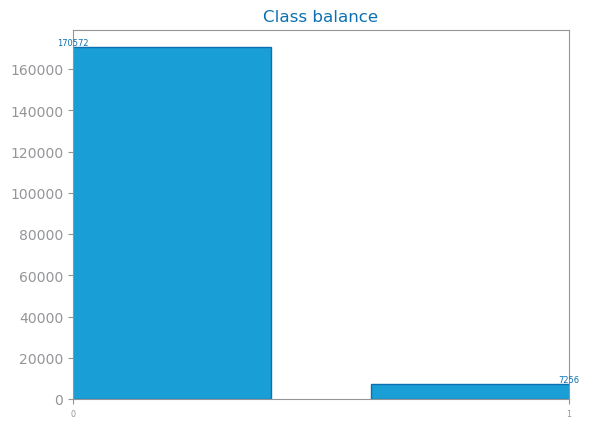

In [32]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart


target_count: Series = df[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

# Balance 1 - Undersampling

## Bal 1 strategy Application

In [33]:
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler



def apply_strategy_1(df: DataFrame) -> DataFrame:

    df_copy=df.copy()

    # this script is available in data_functions originally from DSLabs site in Outlier chapter

    # Ensure positive_class and negative_class are defined and match the target values
    positive_class = 1  # Or whatever your positive class value is
    negative_class = 0  # Or whatever your negative class value is

    # Separate the majority and minority classes
    df_majority = df_copy[df_copy[target] == negative_class]
    df_minority = df_copy[df_copy[target] == positive_class]

    # Check the class distribution
    print(f"Original class distribution:\n{df_copy[target].value_counts(normalize=True) * 100}\n")

    # Downsample the majority class to match the size of the minority class
    df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

    # Combine the downsampled majority class with the minority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # sort  the combined dataset
    df_balanced.sort_values(by='day', inplace=True)
    

    # Check the new class distribution to verify the balance
    print(f"Balanced class distribution:\n{df_balanced[target].value_counts(normalize=True) * 100}\n")

    
    return df_balanced


df_1=apply_strategy_1(train)
test_1=test.copy()


Original class distribution:
conversion
0    96.023426
1     3.976574
Name: proportion, dtype: float64

Balanced class distribution:
conversion
0    50.0
1    50.0
Name: proportion, dtype: float64



Minority class= 0 : 4950
Majority class= 0 : 4950
Proportion: 1.0 : 1


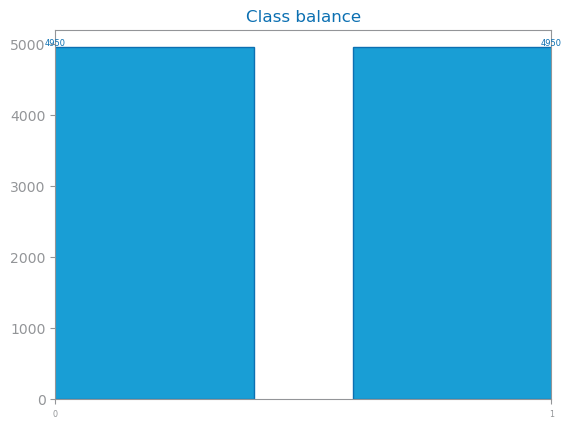

In [34]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart


target_count: Series = df_1[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

## Bal 1 train/test split 

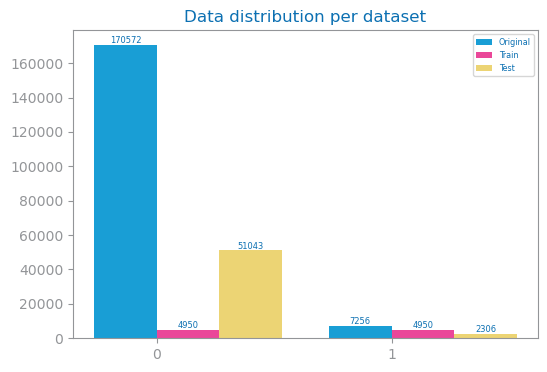

In [35]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}
values["Train"] = [
    len(df_1[df_1[target] == 0]),
    len(df_1[df_1[target] == 1]),
]
values["Test"] = [
    len(test_1[test_1[target] == 0]),
    len(test_1[test_1[target] == 1]),
]
labels = ['0', '1']

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Bal 1 evaluate

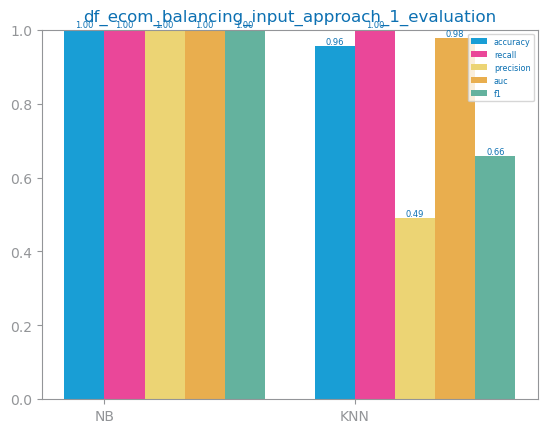

In [36]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

figure()
eval_1: dict[str, list] = evaluate_approach(df_1, test_1, target='conversion', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_1_evaluation", percentage=True
)
savefig(f"images/{file_tag}_approach_1_evaluation.png")
show()

# Bal 2 - SMOTE


## Bal 2 strategy aplication

In [21]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

def apply_strategy_2(df):

   # Copy the DataFrame
    df_copy = df.copy()

    # Define random state for reproducibility
    RANDOM_STATE = 42

    # Separate the features (X) and target (y)
    y = df_copy.pop(target).values
    X: ndarray = df_copy.values

    # Initialize SMOTE
    smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)

    # Fit and resample
    smote_X, smote_y = smote.fit_resample(X, y)

    # Reconstruct the DataFrame from the SMOTE output
    df_smote = concat([DataFrame(smote_X, columns=df_copy.columns), DataFrame(smote_y, columns=[target])], axis=1)


    # Print class distribution and shape
    smote_target_count: Series = Series(smote_y).value_counts()
    print("Minority class=", smote_target_count.index[1], ":", smote_target_count[1])
    print("Majority class=", smote_target_count.index[0], ":", smote_target_count[0])
    print(
        "Proportion:",
        round(smote_target_count[1] / smote_target_count[0], 2),
        ": 1",
    )
    print("Shape of the new DataFrame:", df_smote.shape)

    print("Class counts after SMOTE:")
    print(df_smote[target].value_counts())

    return df_smote

df_2=apply_strategy_2(df)


Minority class= 1 : 170572
Majority class= 0 : 170572
Proportion: 1.0 : 1
Shape of the new DataFrame: (341144, 17)
Class counts after SMOTE:
conversion
0    170572
1    170572
Name: count, dtype: int64


In [86]:
df_2.head()

,category_code_lvl_1,category_code_lvl_2,category_code_lvl_3,price,week_of_month,is_weekend,day,is_view,is_cart,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos,is_purchase
0,6.0,42.0,102.0,128.450000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.817,-0.577,-0.000,1.000,0
1,11.0,57.0,125.0,993.422936,0.0,0.0,0.0,1.0,0.0,-0.0,1.0,1.0,0.0,-0.888,0.460,-1.000,-0.027,0
2,3.0,20.0,62.0,0.790000,0.0,0.0,0.0,1.0,0.0,-0.0,1.0,1.0,0.0,0.979,0.203,-0.921,0.389,0
3,5.0,27.0,76.0,7.390000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.998,-0.068,0.848,-0.530,0
4,0.0,0.0,2.0,427.040000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.942,-0.335,0.848,-0.530,0


In [57]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341144 entries, 0 to 341143
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  341144 non-null  float64
 1   category_code_lvl_2  341144 non-null  float64
 2   category_code_lvl_3  341144 non-null  float64
 3   price                341144 non-null  float64
 4   week_of_month        341144 non-null  float64
 5   is_weekend           341144 non-null  float64
 6   day                  341144 non-null  float64
 7   is_view              341144 non-null  float64
 8   is_cart              341144 non-null  float64
 9   time_of_day_sin      341144 non-null  float64
 10  time_of_day_cos      341144 non-null  float64
 11  day_of_week_sin      341144 non-null  float64
 12  day_of_week_cos      341144 non-null  float64
 13  hour_sin             341144 non-null  float64
 14  hour_cos             341144 non-null  float64
 15  min_sin          

In [87]:
    print("Class counts after SMOTE:")
    print(df_2[target].value_counts())

Class counts after SMOTE:
is_purchase
0    170572
1    170572
Name: count, dtype: int64


## Bal 2 train/test split 

In [92]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(df_2[df_2[target] == 0]),
    len(df_2[df_2[target] == 1]),
]
values["Test"] = [
    len(test_2[test_2[target] == 0]),
    len(test_2[test_2[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

KeyError: 'is_purchase'

In [64]:
print("Train set class distribution:")
print(train_2[target].value_counts())

print("Test set class distribution:")
print(test_2[target].value_counts())

Train set class distribution:
is_purchase
0    170572
1     68228
Name: count, dtype: int64
Test set class distribution:
is_purchase
1    102344
Name: count, dtype: int64


## Bal 2 evaluate

In [25]:

figure()
eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_purchase', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_2, title=f"{file_tag}_approach_2_evaluation", percentage=True
)
#savefig(f"images/{file_tag}_approach_2_evaluation.png")
show()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

<Figure size 640x480 with 0 Axes>

In [27]:
print(df_2[target].value_counts())


KeyError: 'is_purchase'

In [29]:
print(df_2.columns)


Index(['category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3',
       'price', 'week_of_month', 'is_weekend', 'day', 'is_view', 'is_cart',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos'],
      dtype='object')


In [30]:
print(teste_2.columns)

NameError: name 'teste_2' is not defined

In [28]:
print(test_2[target].value_counts())

print(df_2.columns)


KeyError: 'is_purchase'

# Bal 2 - Hybrid

Reduce from negative class from 75 to 60% and then upsample the positives into 50/50


## Bal 2 strategy aplication

In [48]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

def apply_strategy_2(df):

     # Create a copy of the dataframe
    df_copy = df.copy()

    # Define positive and negative classes
    positive_class = 1  # Modify as per your positive class value
    negative_class = 0  # Modify as per your negative class value

    # Separate the majority and minority classes
    df_majority = df_copy[df_copy[target] == negative_class]
    df_minority = df_copy[df_copy[target] == positive_class]

    # Check the current class distribution
    print(f"Original class distribution:\n{df_copy[target].value_counts(normalize=True) * 100}\n")

    # Sort by 'day_of_year' (or another time-related feature) to ensure the data is split based on time
    df_majority.sort_values(by='day', inplace=True)
    df_minority.sort_values(by='day', inplace=True)

    # Determine the number of majority samples for a the desired split
    total_samples = len(df_copy)
    desired_majority_size = int(0.7 * total_samples)

    # Keep the older data for majority class (downsampling based on time, not randomly)
    df_majority_downsampled = df_majority.head(desired_majority_size)

    # Upsample the minority class to match the new majority size for a 50/50 split
    upsample_size = len(df_majority_downsampled)
    df_minority_upsampled = df_minority.sample(n=upsample_size, replace=True)

    # Combine the downsampled majority and upsampled minority classes
    df_balanced = pd.concat([df_majority_downsampled, df_minority_upsampled])

    # Sort the dataset by 'day_of_year' again if needed
    df_balanced.sort_values(by='day', inplace=True)

    # Check the new class distribution
    print(f"Hybrid class distribution:\n{df_balanced[target].value_counts(normalize=True) * 100}\n")

    return df_balanced


df_2=apply_strategy_2(train)
test_2=test.copy()


Original class distribution:
conversion
0    96.023426
1     3.976574
Name: proportion, dtype: float64

Hybrid class distribution:
conversion
0    50.0
1    50.0
Name: proportion, dtype: float64



In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177828 entries, 0 to 177827
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   event_type           177828 non-null  float64
 1   category_code_lvl_1  177828 non-null  float64
 2   category_code_lvl_2  177828 non-null  float64
 3   category_code_lvl_3  177828 non-null  float64
 4   price                177828 non-null  float64
 5   week_of_month        177828 non-null  float64
 6   is_weekend           177828 non-null  float64
 7   day                  177828 non-null  float64
 8   time_of_day_sin      177828 non-null  float64
 9   time_of_day_cos      177828 non-null  float64
 10  day_of_week_sin      177828 non-null  float64
 11  day_of_week_cos      177828 non-null  float64
 12  hour_sin             177828 non-null  float64
 13  hour_cos             177828 non-null  float64
 14  min_sin              177828 non-null  float64
 15  min_cos              1

In [38]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24894 entries, 0 to 122389
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_type           24894 non-null  float64
 1   category_code_lvl_1  24894 non-null  float64
 2   category_code_lvl_2  24894 non-null  float64
 3   category_code_lvl_3  24894 non-null  float64
 4   price                24894 non-null  float64
 5   week_of_month        24894 non-null  float64
 6   is_weekend           24894 non-null  float64
 7   day                  24894 non-null  float64
 8   time_of_day_sin      24894 non-null  float64
 9   time_of_day_cos      24894 non-null  float64
 10  day_of_week_sin      24894 non-null  float64
 11  day_of_week_cos      24894 non-null  float64
 12  hour_sin             24894 non-null  float64
 13  hour_cos             24894 non-null  float64
 14  min_sin              24894 non-null  float64
 15  min_cos              24894 non-null  flo

In [24]:
test_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53349 entries, 0 to 53348
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_type           53349 non-null  float64
 1   category_code_lvl_1  53349 non-null  float64
 2   category_code_lvl_2  53349 non-null  float64
 3   category_code_lvl_3  53349 non-null  float64
 4   price                53349 non-null  float64
 5   week_of_month        53349 non-null  float64
 6   is_weekend           53349 non-null  float64
 7   day                  53349 non-null  float64
 8   time_of_day_sin      53349 non-null  float64
 9   time_of_day_cos      53349 non-null  float64
 10  day_of_week_sin      53349 non-null  float64
 11  day_of_week_cos      53349 non-null  float64
 12  hour_sin             53349 non-null  float64
 13  hour_cos             53349 non-null  float64
 14  min_sin              53349 non-null  float64
 15  min_cos              53349 non-null  floa

## Bal 2 train/test split 

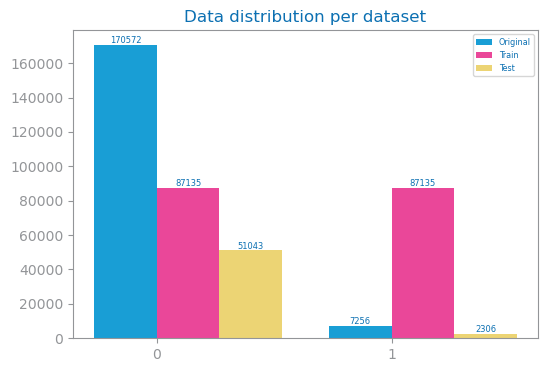

In [49]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(df_2[df_2[target] == 0]),
    len(df_2[df_2[target] == 1]),
]
values["Test"] = [
    len(test_2[test_2[target] == 0]),
    len(test_2[test_2[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Bal 2 evaluate

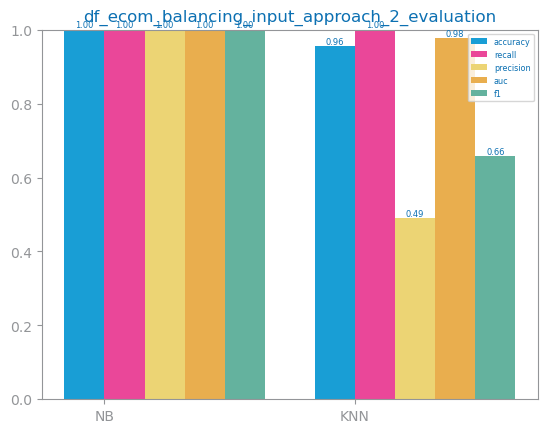

In [50]:

figure()
eval_2: dict[str, list] = evaluate_approach(df_2, test_2, target='conversion', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_2, title=f"{file_tag}_approach_2_evaluation", percentage=True
)
savefig(f"images/{file_tag}_approach_2_evaluation.png")
show()

# Approach uplift comparison

## uplift df

In [51]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

# Calculate uplift
df_uplift = df_eval_2 - df_eval_1



# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



# Display the DataFrame
comparison_df

Approach 1                                         Approach 2  \
              accuracy    recall precision       auc        f1   accuracy   
Naive Bayes   1.000000  1.000000  1.000000  1.000000  1.000000   1.000000   
KNN           0.955126  0.999566  0.490634  0.976342  0.658195   0.955144   

                                                    Uplift            \
            recall precision       auc        f1  accuracy    recall   
Naive Bayes    1.0  1.000000  1.000000  1.000000  0.000000  0.000000   
KNN            1.0  0.490743  0.976559  0.658387  0.000019  0.000434   

                                           
            precision       auc        f1  
Naive Bayes  0.000000  0.000000  0.000000  
KNN          0.000108  0.000217  0.000192

# Analysis

- Uplift between outlier input approaches is specially significant when it comes to recall (55.7%  out1 to 37% out2). 
- Accuracy however is lower on out1 vs out2 treatment strategies
- data processing time is almost equal
- Considering out1 is the best between both strategies, if we compare between previous dataset and outlier treatment, we have
    - an improvement in NB recall (0.35 to 0.55!)
    - slight loss in NB accuracy: 0.63 to 0.59 
    - slight improvement in NB's auc and f1 
    - no significant improvements in KNN

- Considering we seriously want to improve recall, then we will move forward with strategy outlier 1 (thresholding outliers)

# save to csv

In [55]:
if test_data==False:
    
    
    data_save=df.copy()

    data_save=apply_strategy_1(data_save)
        
    data_save.to_csv(f"dataset/df_ecom_2_5_bal_input_v2.csv", index=False)


    print(data_save.columns)



Original class distribution:
conversion
0    95.919653
1     4.080347
Name: proportion, dtype: float64

Balanced class distribution:
conversion
0    50.0
1    50.0
Name: proportion, dtype: float64

Index(['event_type', 'category_code_lvl_1', 'category_code_lvl_2',
       'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'conversion'],
      dtype='object')


## train test csv

In [56]:
if test_data==False:
    

    data_save_copy=data_save.copy()

    
    y, X, labels, class_counts = define_target_and_prepare_data(data_save_copy, target=target)

    train, test = split_data_save_csv(pd.DataFrame(X, columns=data_save_copy.columns), y, data_columns=data_save_copy.columns, target_column=target)  
    
    train.to_csv(f"dataset/df_ecom_2_5_bal_input_v2_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"dataset/df_ecom_2_5_bal_input_v2_test.csv", index=False)
    print(test.columns)

Labels=[0, 1]
Index(['event_type', 'category_code_lvl_1', 'category_code_lvl_2',
       'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'conversion'],
      dtype='object')
Index(['event_type', 'category_code_lvl_1', 'category_code_lvl_2',
       'category_code_lvl_3', 'price', 'week_of_month', 'is_weekend', 'day',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'conversion'],
      dtype='object')
